### **Student Information**

Name: 毛柏毅

Student ID: 111062209

GitHub ID: Dogeon188

Kaggle name: Dogeon188

Kaggle private scoreboard snapshot:

![pic_ranking.png](./pics/my/phase-3.png)


# **Project Report**

---


## 1. Model Development (10 pts Required)


In [4]:
from dotenv import load_dotenv
from google import genai
from google.genai import types, errors
from pydantic import BaseModel, Field, ConfigDict
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import pickle
import os
from tqdm import tqdm
from pathlib import Path
import json
from typing import Literal


In [5]:
DATA_DIR = Path("./data/comp/")

# Load API key from .env file
env_path = "./config/.env"
load_dotenv(dotenv_path=env_path)

True

### 1.1 Preprocessing Steps

#### 1.1.1 Loading Data

First load the raw JSON data into a list of Post objects (validate with Pydantic). Each Post object contains the post ID, text, and hashtags.

In [3]:
with open(DATA_DIR / "final_posts.json", "r") as f:
    raw_posts = json.load(f)
print(f"Total number of posts: {len(raw_posts)}")

Total number of posts: 64171


In [4]:
class PostData(BaseModel):
    model_config = ConfigDict(extra='forbid')

    post_id: str
    text: str
    hashtags: list[str]


class PostSource(BaseModel):
    model_config = ConfigDict(extra='forbid')
    
    post: PostData


class PostRoot(BaseModel):
    model_config = ConfigDict(extra='forbid')
    
    post_type: Literal["post"] = Field(alias="_type")
    source: PostSource = Field(alias="_source")


class Post(BaseModel):
    model_config = ConfigDict(extra='forbid')
    
    root: PostRoot

In [5]:
def validate_post(post):
    try:
        validated_post = Post(**post)
        return validated_post
    except Exception as e:
        raise Exception(f"Validation error for post: {e}, {post}")

posts = list(map(validate_post, raw_posts))

In [6]:
posts[0].root.source.post

PostData(post_id='0x61fc95', text='We got the ranch, loaded our guns and sat up till sunrise.', hashtags=[])

Ensuring the data is correctly structured and validated, we can then convert this list into a pandas DataFrame for easier manipulation and analysis.

In [7]:
df_posts = pd.DataFrame([{
    "id": post.root.source.post.post_id,
    "text": post.root.source.post.text,
    "hashtags": post.root.source.post.hashtags
} for post in posts])

In [8]:
df_posts.head()

,id,text,hashtags
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[]
1,0x35663e,I bet there is an army of married couples who ...,[]
2,0xc78afe,This could only end badly.,[]
3,0x90089c,My sister squeezed a lime in her milk when she...,[]
4,0xaba820,and that got my head bobbing a little bit.,[]


There are still 3 more CSV files provided for this task:

- `data_identification.csv`: Contains the mapping between post IDs and their train/test split.
- `emotion.csv`: Contains the mapping between post IDs (train only) and their emotion labels.
- `samplesubmission.csv`: Contains the post IDs for the test set and a placeholder for predicted emotion labels. We don't need to handle this file in preprocessing.

In [9]:
df_identification = pd.read_csv(DATA_DIR / "data_identification.csv")
df_emotion = pd.read_csv(DATA_DIR / "emotion.csv")

df_merged = df_posts.merge(df_identification, on="id", how="left")
df_merged = df_merged.merge(df_emotion, on="id", how="left")

In [10]:
df_merged.head()

,id,text,hashtags,split,emotion
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[],test,NaN
1,0x35663e,I bet there is an army of married couples who ...,[],train,joy
2,0xc78afe,This could only end badly.,[],train,fear
3,0x90089c,My sister squeezed a lime in her milk when she...,[],train,joy
4,0xaba820,and that got my head bobbing a little bit.,[],test,NaN


#### 1.1.2 Data Exploration

Let's first see the label distribution in the dataset.

<Axes: title={'center': 'Distribution of Emotions in Dataset'}, xlabel='emotion'>

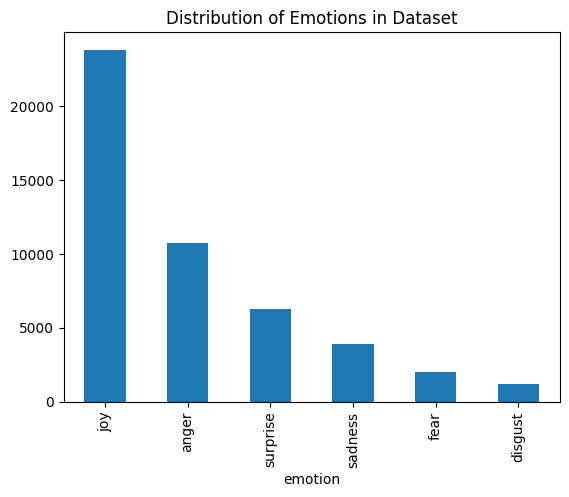

In [11]:
df_merged["emotion"].value_counts().plot(kind="bar", title="Distribution of Emotions in Dataset")

Seems quite imbalanced, with `joy` being the most frequent emotion and `disgust` the least.

The `hashtags` column contains lists of hashtags associated with each post. Let's explore the unique hashtags present in the dataset.

In [12]:
from collections import Counter

hashtag_counter = Counter()
for hashtags in df_merged['hashtags']:
    hashtag_counter.update(hashtags)

print(f"Unique hashtag count: {len(hashtag_counter)}")
print("Most common hashtags:")
for i, (tag, count) in enumerate(hashtag_counter.most_common(64)):
    print(f"{tag}({count})", end="")
    print("\t" if i % 8 != 7 else "\n", end="")

Unique hashtag count: 3403
Most common hashtags:
sad(73)	happy(73)	fear(62)	smile(61)	anxiety(58)	depression(58)	nervous(54)	musically(54)
angry(54)	terrorism(53)	hilarious(52)	awful(52)	blues(52)	sadness(51)	nightmare(51)	terrible(50)
lost(50)	shocking(48)	bitter(47)	gbbo(47)	optimism(47)	anger(45)	fuming(44)	terror(43)
horror(42)	rage(40)	bully(37)	revenge(37)	panic(36)	horrible(36)	sober(36)	quote(34)
bb18(32)	serious(32)	love(32)	1(31)	unhappy(31)	lively(31)	afraid(30)	depressing(29)
laughter(28)	offended(27)	start(27)	dark(26)	pakistan(25)	success(24)	glee(24)	snap(24)
life(23)	lol(23)	worry(23)	outrage(22)	trump(20)	excited(19)	funny(19)	india(19)
restless(17)	smiling(17)	faith(16)	music(16)	relentless(15)	snapchat(15)	cheer(14)	joy(14)


In [13]:
all_hashtags = list(hashtag_counter.keys())

There are many (thousands of) unique hashtags in the dataset. Fortunately for us, many frequent hashtags are related to emotions, such as `#sad`, `#happy`, `#fear`, etc. Perhaps we can leverage the word embeddings of these hashtags (aggregated in some way) as additional features for our model.

### 1.2 Feature Engineering Steps

#### 1.2.1 Gemini API Settings

Setting up the API client and model parameters.

In [14]:
# We input the API Key to be able to use the Gemini models
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key  # type: ignore
client = genai.Client(api_key=api_key)

To avoid hitting rate limits when making API calls, we can implement a rate-limiting decorator. It keeps track of the timestamps of recent calls and ensures we don't exceed the allowed number of calls per minute. This would be a more elegant solution than just adding fixed sleep intervals between calls.

[Check API Rate Limits](https://aistudio.google.com/usage?tab=rate-limit)

In [15]:
from queue import Queue
from time import time, sleep


def rate_limit_guard(rpm: int = 100, interval_sec: int = 60, wait_padding_sec: float = 0, verbose: bool = False):
    """A decorator to limit the rate of function calls.
    
    Args:
        rpm (int): Maximum number of calls allowed per interval.
        interval_sec (int): Time interval in seconds.
        wait_padding_sec (float): Additional padding time to wait in seconds.
        verbose (bool): If True, prints wait time when rate limit is exceeded.
    """
    def decorator(func):
        func.call_history = Queue()

        def wrapper(*args, **kwargs):
            current_time = time()
            while not func.call_history.empty():
                call_time = func.call_history.queue[0]
                if current_time - call_time > interval_sec:
                    func.call_history.get()
                else:
                    break
            if func.call_history.qsize() >= rpm:
                wait_time = interval_sec - \
                    (current_time - func.call_history.queue[0]) + wait_padding_sec
                if verbose:
                    print(
                        f"Rate limit exceeded. Waiting for {wait_time:.2f} seconds.")
                sleep(wait_time)
            func.call_history.put(time())
            return func(*args, **kwargs)
        return wrapper
    return decorator

In [16]:
embedding_models = [
    m.name.removeprefix("models/")
    for m in client.models.list()
    if m.supported_actions and 'embedContent' in m.supported_actions and m.name]
print("Available embedding models:")
for model in embedding_models:
    print(f"- {model}")

Available embedding models:
- embedding-001
- text-embedding-004
- gemini-embedding-exp-03-07
- gemini-embedding-exp
- gemini-embedding-001


In [17]:
# 100 requests per minute limit
@rate_limit_guard(rpm=100, interval_sec=60, wait_padding_sec=5)
def get_gemini_embeddings_one_batch(
    contents: list[str],
    model: str = "gemini-embedding-001"
) -> list[types.ContentEmbedding] | None:
    """Fetches the embedding for the given text using the specified Gemini model.
    """
    # if model not in embedding_models:
    #     raise ValueError(f"Model {model} is not available for embeddings.")
    # if len(contents) > 100:
    #     raise ValueError("Batch size exceeds the maximum limit of 100.")
    try:
        result = client.models.embed_content(model=model, contents=contents)
        return result.embeddings
    except errors.ClientError as e:
        if e.details["error"]["status"] == "RESOURCE_EXHAUSTED":
            print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
            sleep(5)  # Wait for 5 seconds before the next attempt
            return get_gemini_embeddings_one_batch(contents, model)  # Retry the request
        else:
            print("Unexpected ClientError:", e)
            return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None
    
def get_gemini_embeddings(
    contents: list[str],
    model: str = "gemini-embedding-001",
    batch_size: int = 100
) -> list[types.ContentEmbedding] | None:
    """Fetches embeddings for a list of contents in batches using the specified Gemini model.
    """
    if model not in embedding_models:
        raise ValueError(f"Model {model} is not available for embeddings.")
    if batch_size > 100:
        raise ValueError("Batch size exceeds the maximum limit of 100.")
    
    all_embeddings = []
    for i in tqdm(range(0, len(contents), batch_size), desc="Fetching embeddings in batches"):
        batch_contents = contents[i:i + batch_size]
        batch_embeddings = get_gemini_embeddings_one_batch(batch_contents, model)
        if batch_embeddings is None:
            print(f"Failed to get embeddings for batch starting at index {i}.")
            return None
        all_embeddings.extend(batch_embeddings)
    return all_embeddings


#### 1.2.2 Hashtag Embeddings

Let's first convert the hashtags into embeddings using the Gemini API.

In [20]:
hashtag_embeddings = get_gemini_embeddings(
    contents=all_hashtags,
    model="text-embedding-004"
)

Fetching embeddings in batches: 100%|██████████| 35/35 [00:42<00:00,  1.23s/it]


In [ ]:
hashtag_embeddings_dict = {
    tag: np.array(embedding.values)
    for tag, embedding in zip(all_hashtags, hashtag_embeddings)
}

In [37]:
# save embeddings to a pickle file
pickle.dump(hashtag_embeddings_dict, open(DATA_DIR / "hashtag_embeddings.pkl", "wb"))

In [18]:
hashtag_embeddings_dict = pickle.load(open(DATA_DIR / "hashtag_embeddings.pkl", "rb"))

Now let's visualize the distribution of these hashtag embeddings using 3D UMAP.

In [19]:
import umap
import plotly.express as px


def plot_umap(
    df: pd.DataFrame,
    label_col: str | None = None,
    hover_cols: list[str] | None = None,
    color_col: str | None = None,
    size_col: str | None = None,
    size_max: float | None = None,
    embedding_col: str = "embedding",
    kind: Literal["2d", "3d"] = "2d"
):

    reducer = umap.UMAP(n_components=3 if kind == "3d" else 2,
                        random_state=42, metric='cosine')
    embeddings = np.array(df[embedding_col].tolist())
    embeddings = reducer.fit_transform(embeddings)

    if kind == "2d":
        df_plot = df.copy()
        df_plot[['umap_x', 'umap_y']] = pd.DataFrame(
            embeddings, index=df.index)

        fig = px.scatter(
            df_plot,
            x='umap_x', y='umap_y',
            hover_data=hover_cols,
            text=label_col,
            color=color_col,
            size=size_col,
            title="2D UMAP of Hashtag Embeddings",
            width=800, height=600
        )
        if size_col is None and size_max is not None:
            fig.update_traces(marker=dict(size=size_max))
        fig.show()
    else:  # type == "3d"
        df_plot = df.copy()
        df_plot[['umap_x', 'umap_y', 'umap_z']] = pd.DataFrame(
            embeddings, index=df.index)

        fig = px.scatter_3d(
            df_plot,
            x='umap_x', y='umap_y', z='umap_z',
            hover_data=hover_cols,
            text=label_col,
            color=color_col,
            size=size_col,
            title="3D UMAP of Hashtag Embeddings",
            width=800, height=600
        )
        if size_col is None and size_max is not None:
            fig.update_traces(marker=dict(size=size_max))
        fig.show()

2025-11-24 02:41:30.189549: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-24 02:41:30.337229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-24 02:41:30.874052: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


To better illustrate the discrimination between different hashtags, we first apply K-means clustering to group similar hashtags together, and then visualize the clusters in 3D UMAP space.

In [20]:
from sklearn.cluster import KMeans


plot_df = pd.DataFrame({
    "hashtag": all_hashtags,
    "embedding": [hashtag_embeddings_dict[tag] for tag in all_hashtags]
})

# apply k-means clustering to group similar hashtags together

kmeans_hashtags = KMeans(n_clusters=10, random_state=42)
kmeans_hashtags.fit(np.array(plot_df["embedding"].tolist()))
plot_df["cluster"] = kmeans_hashtags.labels_
plot_df["dist"] = kmeans_hashtags.transform(
    np.array(plot_df["embedding"].tolist())
).min(axis=1)
plot_df["dist"] = plot_df["dist"].apply(
    lambda x: (x - plot_df["dist"].min()) / (plot_df["dist"].max() - plot_df["dist"].min())
)
plot_df["dist"] = plot_df["dist"].apply(lambda x: x ** 4)  # for better size discrimination
plot_df["cluster"] = plot_df["cluster"].astype(str)  # for better color mapping

In [21]:
for cluster_id in sorted(plot_df["cluster"].unique()):
    print(f"Cluster {cluster_id} representative hashtags:")
    top_tags = plot_df[plot_df["cluster"] == cluster_id].sort_values(
        by="dist", ascending=True).head(5)["hashtag"].tolist()
    print("\t", ", ".join(top_tags))

Cluster 0 representative hashtags:
	 notyet, nooneisalone, youvegottobekiddingme, usapleasedont, nothanks
Cluster 1 representative hashtags:
	 newyork, trump, hillaryclinton, nyc, boston
Cluster 2 representative hashtags:
	 news, video, religion, music, christianity
Cluster 3 representative hashtags:
	 stupidity, shitsucks, idiots, bullshit, losers
Cluster 4 representative hashtags:
	 twat, rawr, spooky, cat, dog
Cluster 5 representative hashtags:
	 selfimprovement, personaldevelopment, wisewords, selfhelp, tuesdaythought
Cluster 6 representative hashtags:
	 الخفجي, सत, アニメ, the, اليوم_الوطني
Cluster 7 representative hashtags:
	 getsauced, hellloooootwitter, rocktheretweet, getitgirl, loveisand
Cluster 8 representative hashtags:
	 joyful, happy, cheerful, joyous, wonderful
Cluster 9 representative hashtags:
	 sadness, distressed, sad, frustrated, saddened


In the above representative hashtags from each cluster, we can see some sense of emotions for each cluster, e.g. cluster 9 represents sadness, cluster 8 represents joy, and cluster 2 are neutral hashtags.

In [22]:
plot_umap(
    df=plot_df,
    hover_cols=["hashtag"],
    color_col="cluster",
    size_col="dist",
    kind="3d"
)

/home/dogeon/dm-2025/lab2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Unfortunately, there seems no clear boundary between different clusters in the UMAP plot. Perhaps this is because the word embeddings of hashtags are already highly compressed representations, and further dimensionality reduction with UMAP may lose some important information. Nevertheless, we will still attempt to use these hashtag embeddings as additional features for our model.

For now, we can aggregate the hashtag embeddings for each post by taking the mean of the embeddings of all hashtags associated with that post. If there are no hashtags, we can use a zero vector as the embedding.

In [23]:
def aggregate_hashtag_embeddings(
    hashtags: list[str],
    embedding_dict: dict[str, np.ndarray],
    embedding_dim: int = 768
) -> np.ndarray:
    if not hashtags:
        return np.zeros(embedding_dim)

    # Get the embeddings for the hashtags
    embeddings = [embedding_dict.get(tag, np.zeros(embedding_dim)) for tag in hashtags]
    # Return the mean of the embeddings
    return np.mean(embeddings, axis=0)

df_merged["hashtag_embedding"] = df_merged["hashtags"].apply(
    lambda tags: aggregate_hashtag_embeddings(
        tags,
        hashtag_embeddings_dict,
        embedding_dim=len(next(iter(hashtag_embeddings_dict.values())))
    )
)

In [24]:
df_merged[df_merged["hashtags"].apply(len) > 0][["hashtags", "hashtag_embedding"]].head()

,hashtags,hashtag_embedding
14,"[badd, wicked, bright]","[-0.047749574999999995, -0.012394224333333334,..."
41,"[lifechanging, sad, happy, emotionalrollercoas...","[0.022812601874999998, -0.031855646975, 0.0199..."
55,"[sad, nevertrump]","[0.0243623165, -0.0380359135, 0.00335818199999..."
60,[nevertrump],"[0.030582117, -0.05871542, -0.042564586, -0.03..."
61,"[nervous, excited]","[0.017024095, -0.043110255, 0.0310002935, 0.01..."


#### 1.2.3 Post Text Embeddings

Similarly, we'll convert the post texts into embeddings using the Gemini API.

In [28]:
text_embeddings = get_gemini_embeddings(
    contents=df_merged["text"].tolist(),
    model="text-embedding-004"
)

Fetching embeddings in batches: 100%|██████████| 642/642 [13:54<00:00,  1.30s/it]


In [29]:
df_merged["text_embedding"] = [np.array(embedding.values) for embedding in text_embeddings]

In [30]:
df_merged.to_pickle(DATA_DIR / "df_merged_with_text_embeddings.pkl")

In [31]:
df_merged = pd.read_pickle(DATA_DIR / "df_merged_with_text_embeddings.pkl")

In [32]:
df_merged.head()

,id,text,hashtags,split,emotion,hashtag_embedding,text_embedding
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[],test,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0074587376, 0.0094784545, 0.0024528992, 0.0..."
1,0x35663e,I bet there is an army of married couples who ...,[],train,joy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01895659, 0.00072769175, -0.00050007005, -..."
2,0xc78afe,This could only end badly.,[],train,fear,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01238031, -0.00046374192, 0.004575007, -0.0..."
3,0x90089c,My sister squeezed a lime in her milk when she...,[],train,joy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.012005463, 0.007308754, -0.055489037, 0.060..."
4,0xaba820,and that got my head bobbing a little bit.,[],test,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.028398054, -0.043395437, -0.014858938, 0.04..."


In [33]:
plot_umap(
    df=df_merged[df_merged["split"] == "train"].sample(n=3000, random_state=42),
    embedding_col="text_embedding",
    hover_cols=["text", "hashtags"],
    color_col="emotion",
    size_max=4,
    kind="3d"
)

/home/dogeon/dm-2025/lab2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Similar to the observation with hashtag embeddings, the UMAP plot of text embeddings also shows no clear cluster boundaries. We can only see vague boundary among part of `joy` emotions, but other emotions are quite mixed together.

This could be due to the same reason mentioned earlier - the text embeddings are already compressed representations, and further dimensionality reduction may lose important information.

### 1.3 Model Implementation

#### 1.3.1 Train Test Split

In [34]:
df_train = df_merged[df_merged['split'] == 'train'].reset_index(drop=True)
df_test = df_merged[df_merged['split'] == 'test'].reset_index(drop=True)

In [35]:
df_train.to_pickle(DATA_DIR / "df_train_final.pkl")
df_test.to_pickle(DATA_DIR / "df_test_final.pkl")

In [6]:
df_train = pd.read_pickle(DATA_DIR / "df_train_final.pkl")
df_test = pd.read_pickle(DATA_DIR / "df_test_final.pkl")

In [7]:
print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

Training set size: 47890
Test set size: 16281


In [8]:
df_train.head()

,id,text,hashtags,split,emotion,hashtag_embedding,text_embedding
0,0x35663e,I bet there is an army of married couples who ...,[],train,joy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01895659, 0.00072769175, -0.00050007005, -..."
1,0xc78afe,This could only end badly.,[],train,fear,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01238031, -0.00046374192, 0.004575007, -0.0..."
2,0x90089c,My sister squeezed a lime in her milk when she...,[],train,joy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.012005463, 0.007308754, -0.055489037, 0.060..."
3,0x2ffb63,Thank you so much❤️,[],train,joy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0032902658, -0.015828965, 0.002385771, 0.0..."
4,0x989146,Stinks because ive been in this program for a ...,[],train,joy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.057019755, -0.02723884, 0.008149491, 0.0590..."


#### 1.3.2 DataLoader Preparation

In [9]:
# split train into train and val
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train["emotion"]
)

In [10]:
emotion_labels = sorted(df_train["emotion"].unique())
label_to_idx = {label: idx for idx, label in enumerate(emotion_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
print("Label to Index mapping:")
for label, idx in label_to_idx.items():
    print(f"{label}: {idx}")

Label to Index mapping:
anger: 0
disgust: 1
fear: 2
joy: 3
sadness: 4
surprise: 5


In [11]:
class EmotionDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text_embedding = torch.tensor(row["text_embedding"], dtype=torch.float32)
        hashtag_embedding = torch.tensor(
            row["hashtag_embedding"], dtype=torch.float32)
        label = torch.tensor(label_to_idx[row["emotion"]], dtype=torch.long)
        return text_embedding, hashtag_embedding, label

In [12]:
loader_batch_size = 64

In [13]:
dataset_train = EmotionDataset(df_train)
train_loader = DataLoader(dataset_train, batch_size=loader_batch_size, shuffle=True)

dataset_val = EmotionDataset(df_val)
val_loader = DataLoader(dataset_val, batch_size=loader_batch_size, shuffle=False)

#### 1.3.2 Model Training

In [55]:
class ClassifierModel(torch.nn.Module):
    def __init__(
            self,
            input_dim: int,
            hidden_dim: int,
            output_dim: int,
            n_experts_text: int = 3,
            n_experts_tag: int = 3,
            dropout_rate: float = 0.5):
        super(ClassifierModel, self).__init__()

        self.n_experts_text = n_experts_text
        self.n_experts_tag = n_experts_tag

        self.nets_text = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.LayerNorm(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout_rate),
                torch.nn.Linear(hidden_dim, output_dim)
            ) for _ in range(n_experts_text)
        ])
        self.nets_tag = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.LayerNorm(hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout_rate),
                torch.nn.Linear(hidden_dim, output_dim)
            ) for _ in range(n_experts_tag)
        ])
        self.weights_text = torch.nn.Parameter(torch.tensor(0.7))
        self.weights_tag = torch.nn.Parameter(torch.tensor(0.3))

        for net in self.nets_text:
            for layer in net:
                if isinstance(layer, torch.nn.Linear):
                    torch.nn.init.xavier_uniform_(layer.weight)
        for net in self.nets_tag:
            for layer in net:
                if isinstance(layer, torch.nn.Linear):
                    torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x_text, x_tag):
        outs_text = [net(x_text) for net in self.nets_text]
        outs_tag = [net(x_tag) for net in self.nets_tag]
        logs_text = torch.log_softmax(torch.stack(outs_text), dim=0) if self.n_experts_text > 0 else torch.tensor([0])
        logs_tag = torch.log_softmax(torch.stack(outs_tag), dim=0) if self.n_experts_tag > 0 else torch.tensor([0])
        out = sum(logs_text) * self.weights_text + sum(logs_tag) * self.weights_tag
        return out

In [56]:
from sklearn.metrics import f1_score


def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    criterion,
    optimizer,
    num_epochs: int = 25,
    device: str = 'cpu'
):
    val_labels = []
    for _, _, labels in val_loader:
        val_labels.extend(labels.numpy())

    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_means = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for text_emb, tag_emb, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", total=len(train_loader)):
            text_emb, tag_emb, labels = text_emb.to(device), tag_emb.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(text_emb, tag_emb)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * text_emb.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        correct_predictions = 0
        all_preds = []
        with torch.no_grad():
            for text_emb, tag_emb, labels in tqdm(val_loader, desc="Validation", total=len(val_loader)):
                text_emb, tag_emb, labels = text_emb.to(device), tag_emb.to(device), labels.to(device)
                outputs = model(text_emb, tag_emb)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * text_emb.size(0)

                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)

                all_preds.append(preds)
        
        all_preds = torch.cat(all_preds).cpu().numpy()
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = correct_predictions.double() / len(val_loader.dataset)
        val_f1_mean = f1_score(val_labels, all_preds, average='weighted')

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy.item())
        val_f1_means.append(val_f1_mean)

        print(f'Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}, Mean F1: {val_f1_mean:.4f}')

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_f1_means": val_f1_means
    }

In [57]:
class_counts = df_train['emotion'].value_counts().sort_index().values
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to('cuda')

In [67]:
model = ClassifierModel(
    input_dim=768,
    hidden_dim=256,
    output_dim=len(df_train["emotion"].unique()),
    dropout_rate=0.5,
    n_experts_text=3,
    n_experts_tag=3
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

In [68]:
train_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device='cuda'
)

Epoch 1/25: 100%|██████████| 599/599 [00:01<00:00, 355.77it/s]


Epoch 1/25, Training Loss: 1.1072


Validation: 100%|██████████| 150/150 [00:00<00:00, 680.94it/s]


Validation Loss: 0.9571, Accuracy: 0.6468, Mean F1: 0.6208


Epoch 2/25: 100%|██████████| 599/599 [00:01<00:00, 356.47it/s]


Epoch 2/25, Training Loss: 0.9669


Validation: 100%|██████████| 150/150 [00:00<00:00, 678.75it/s]


Validation Loss: 0.9424, Accuracy: 0.6503, Mean F1: 0.6282


Epoch 3/25: 100%|██████████| 599/599 [00:01<00:00, 367.85it/s]


Epoch 3/25, Training Loss: 0.9287


Validation: 100%|██████████| 150/150 [00:00<00:00, 647.53it/s]


Validation Loss: 0.9399, Accuracy: 0.6524, Mean F1: 0.6288


Epoch 4/25: 100%|██████████| 599/599 [00:01<00:00, 381.15it/s]


Epoch 4/25, Training Loss: 0.8999


Validation: 100%|██████████| 150/150 [00:00<00:00, 615.03it/s]


Validation Loss: 0.9381, Accuracy: 0.6556, Mean F1: 0.6396


Epoch 5/25: 100%|██████████| 599/599 [00:01<00:00, 378.39it/s]


Epoch 5/25, Training Loss: 0.8754


Validation: 100%|██████████| 150/150 [00:00<00:00, 668.74it/s]


Validation Loss: 0.9363, Accuracy: 0.6557, Mean F1: 0.6365


Epoch 6/25: 100%|██████████| 599/599 [00:01<00:00, 352.82it/s]


Epoch 6/25, Training Loss: 0.8489


Validation: 100%|██████████| 150/150 [00:00<00:00, 681.07it/s]


Validation Loss: 0.9358, Accuracy: 0.6605, Mean F1: 0.6415


Epoch 7/25: 100%|██████████| 599/599 [00:01<00:00, 360.43it/s]


Epoch 7/25, Training Loss: 0.8244


Validation: 100%|██████████| 150/150 [00:00<00:00, 687.69it/s]


Validation Loss: 0.9501, Accuracy: 0.6575, Mean F1: 0.6340


Epoch 8/25: 100%|██████████| 599/599 [00:01<00:00, 359.01it/s]


Epoch 8/25, Training Loss: 0.7922


Validation: 100%|██████████| 150/150 [00:00<00:00, 686.36it/s]


Validation Loss: 0.9519, Accuracy: 0.6593, Mean F1: 0.6462


Epoch 9/25: 100%|██████████| 599/599 [00:01<00:00, 331.75it/s]


Epoch 9/25, Training Loss: 0.7641


Validation: 100%|██████████| 150/150 [00:00<00:00, 669.79it/s]


Validation Loss: 0.9616, Accuracy: 0.6549, Mean F1: 0.6398


Epoch 10/25: 100%|██████████| 599/599 [00:01<00:00, 352.42it/s]


Epoch 10/25, Training Loss: 0.7308


Validation: 100%|██████████| 150/150 [00:00<00:00, 672.13it/s]


Validation Loss: 0.9707, Accuracy: 0.6588, Mean F1: 0.6417


Epoch 11/25: 100%|██████████| 599/599 [00:01<00:00, 359.04it/s]


Epoch 11/25, Training Loss: 0.6993


Validation: 100%|██████████| 150/150 [00:00<00:00, 662.51it/s]


Validation Loss: 0.9839, Accuracy: 0.6570, Mean F1: 0.6409


Epoch 12/25: 100%|██████████| 599/599 [00:01<00:00, 354.81it/s]


Epoch 12/25, Training Loss: 0.6692


Validation: 100%|██████████| 150/150 [00:00<00:00, 671.93it/s]


Validation Loss: 1.0074, Accuracy: 0.6557, Mean F1: 0.6373


Epoch 13/25: 100%|██████████| 599/599 [00:01<00:00, 350.35it/s]


Epoch 13/25, Training Loss: 0.6435


Validation: 100%|██████████| 150/150 [00:00<00:00, 667.66it/s]


Validation Loss: 1.0495, Accuracy: 0.6451, Mean F1: 0.6376


Epoch 14/25: 100%|██████████| 599/599 [00:01<00:00, 357.94it/s]


Epoch 14/25, Training Loss: 0.6113


Validation: 100%|██████████| 150/150 [00:00<00:00, 679.30it/s]


Validation Loss: 1.0385, Accuracy: 0.6508, Mean F1: 0.6405


Epoch 15/25: 100%|██████████| 599/599 [00:01<00:00, 360.86it/s]


Epoch 15/25, Training Loss: 0.5819


Validation: 100%|██████████| 150/150 [00:00<00:00, 664.94it/s]


Validation Loss: 1.0871, Accuracy: 0.6539, Mean F1: 0.6343


Epoch 16/25: 100%|██████████| 599/599 [00:01<00:00, 357.55it/s]


Epoch 16/25, Training Loss: 0.5530


Validation: 100%|██████████| 150/150 [00:00<00:00, 678.46it/s]


Validation Loss: 1.0990, Accuracy: 0.6541, Mean F1: 0.6400


Epoch 17/25: 100%|██████████| 599/599 [00:01<00:00, 354.73it/s]


Epoch 17/25, Training Loss: 0.5287


Validation: 100%|██████████| 150/150 [00:00<00:00, 679.36it/s]


Validation Loss: 1.1254, Accuracy: 0.6446, Mean F1: 0.6368


Epoch 18/25: 100%|██████████| 599/599 [00:01<00:00, 379.12it/s]


Epoch 18/25, Training Loss: 0.5081


Validation: 100%|██████████| 150/150 [00:00<00:00, 649.19it/s]


Validation Loss: 1.1317, Accuracy: 0.6393, Mean F1: 0.6335


Epoch 19/25: 100%|██████████| 599/599 [00:01<00:00, 375.94it/s]


Epoch 19/25, Training Loss: 0.4820


Validation: 100%|██████████| 150/150 [00:00<00:00, 646.60it/s]


Validation Loss: 1.1757, Accuracy: 0.6424, Mean F1: 0.6311


Epoch 20/25: 100%|██████████| 599/599 [00:01<00:00, 355.50it/s]


Epoch 20/25, Training Loss: 0.4634


Validation: 100%|██████████| 150/150 [00:00<00:00, 658.47it/s]


Validation Loss: 1.2245, Accuracy: 0.6471, Mean F1: 0.6276


Epoch 21/25: 100%|██████████| 599/599 [00:01<00:00, 353.42it/s]


Epoch 21/25, Training Loss: 0.4434


Validation: 100%|██████████| 150/150 [00:00<00:00, 671.53it/s]


Validation Loss: 1.2254, Accuracy: 0.6448, Mean F1: 0.6306


Epoch 22/25: 100%|██████████| 599/599 [00:01<00:00, 352.48it/s]


Epoch 22/25, Training Loss: 0.4298


Validation: 100%|██████████| 150/150 [00:00<00:00, 604.27it/s]


Validation Loss: 1.2483, Accuracy: 0.6414, Mean F1: 0.6231


Epoch 23/25: 100%|██████████| 599/599 [00:01<00:00, 361.22it/s]


Epoch 23/25, Training Loss: 0.4091


Validation: 100%|██████████| 150/150 [00:00<00:00, 674.33it/s]


Validation Loss: 1.2995, Accuracy: 0.6442, Mean F1: 0.6273


Epoch 24/25: 100%|██████████| 599/599 [00:01<00:00, 358.37it/s]


Epoch 24/25, Training Loss: 0.3948


Validation: 100%|██████████| 150/150 [00:00<00:00, 677.52it/s]


Validation Loss: 1.2815, Accuracy: 0.6436, Mean F1: 0.6308


Epoch 25/25: 100%|██████████| 599/599 [00:01<00:00, 365.79it/s]


Epoch 25/25, Training Loss: 0.3832


Validation: 100%|██████████| 150/150 [00:00<00:00, 676.11it/s]

Validation Loss: 1.3363, Accuracy: 0.6425, Mean F1: 0.6272


In [69]:
print(f"Final Weights - Text: {model.weights_text.item():.4f}, Hashtag: {model.weights_tag.item():.4f}")

Final Weights - Text: 1.6687, Hashtag: 0.2767


<Axes: >

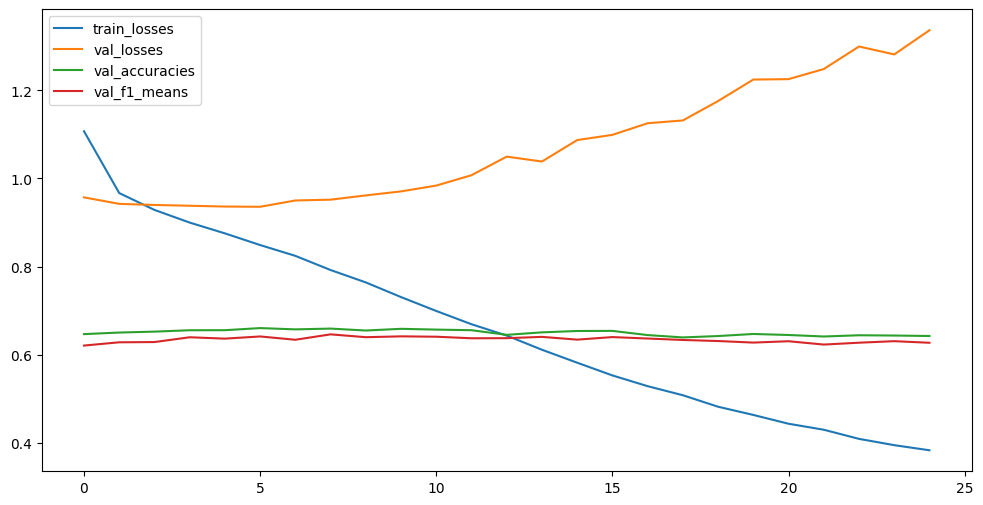

In [70]:
pd.DataFrame(train_history).plot(figsize=(12, 6))

Evaluating on Validation Set: 100%|██████████| 150/150 [00:00<00:00, 685.75it/s]


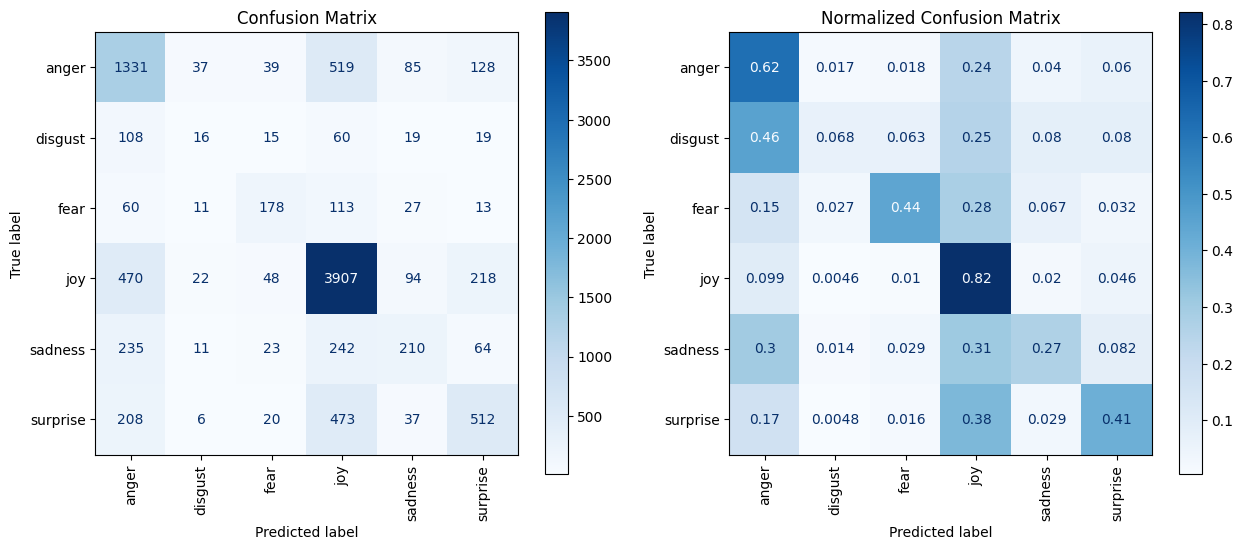

In [71]:
# plot the confusion matrix on the val set
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for text_emb, tag_emb, labels in tqdm(val_loader, desc="Evaluating on Validation Set", total=len(val_loader)):
        text_emb, tag_emb = text_emb.to('cuda'), tag_emb.to('cuda')
        outputs = model(text_emb, tag_emb)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=emotion_labels)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax[0])
disp_norm.plot(cmap='Blues', xticks_rotation='vertical', ax=ax[1])

ax[0].set_title("Confusion Matrix")
ax[1].set_title("Normalized Confusion Matrix")

plt.show()

The label imbalance is quite significant in this dataset, as shown in the predictions being heavily biased towards the majority class `joy`. Even though applying class weights should help alleviate this issue, it instead seems to worsen the performance.

#### 1.3.3 Prediction on Test Set

In [72]:
# Evaluate on Test Set
all_test_preds = []

for row in tqdm(df_test.itertuples(), total=len(df_test), desc="Evaluating on Test Set"):
    text_emb = torch.tensor(row.text_embedding, dtype=torch.float32).unsqueeze(0).to('cuda')
    tag_emb = torch.tensor(row.hashtag_embedding, dtype=torch.float32).unsqueeze(0).to('cuda')

    with torch.no_grad():
        outputs = model(text_emb, tag_emb)
        _, pred = torch.max(outputs, 1)

    all_test_preds.append(pred.cpu().item())

Evaluating on Test Set: 100%|██████████| 16281/16281 [00:04<00:00, 3783.29it/s]


In [73]:
df_test['predicted_emotion'] = [idx_to_label[idx] for idx in all_test_preds]
df_test[['id', 'predicted_emotion']].head()

,id,predicted_emotion
0,0x61fc95,joy
1,0xaba820,joy
2,0x66e44d,joy
3,0xc03cf5,joy
4,0x02f65a,anger


In [74]:
df_test[["id", "predicted_emotion"]].to_csv(DATA_DIR / "test_set_predictions.csv", index=False)

In [75]:
submit_message = input("Enter submission message: ")
if submit_message.strip() != "":
    !kaggle competitions submit -c dm-lab-2-private-competition -f ./data${DATA_DIR / "test_set_predictions.csv"} -m "{submit_message}"
else:
    print("Submission message is empty. Skipping submission.")

100%|█████████████████████████████████████████| 227k/227k [00:01<00:00, 191kB/s]
Successfully submitted to DM Lab 2 Private Competition

---

## 2. Bonus Section (5 pts Optional)

### 2.1 Mention Different Things You Tried

<table>
<tr>
<th>ID</th>
<th>Method</th>
<th>Description</th>
<th>Result (Public Score)</th>
<th>Result (Private Score)</th>
</tr>
<tr>
<td>(1)</td>
<td>Text + Hashtag</td>
<td>Passing both text and hashtag embeddings through separate classifier networks (1 layer FCN), then averaging their outputs.</td>
<td>0.6480</td>
<td>0.6377</td>
</tr>
<tr>
<td>(2)</td>
<td>Text + Hashtag with Learnable Weights</td>
<td>Similar to above, but with learnable weights to combine the outputs of text and hashtag classifiers.</td>
<td>0.6549</td>
<td>0.6500</td>
</tr>
<tr>
<td>(3)</td>
<td>Product of Experts</td>
<td>Using the product of experts approach to combine the outputs of multiple experts (3 for text, 3 for hashtag) with learnable weights.</td>
<td>0.6339</td>
<td>0.6344</td>
</tr>
<tr>
<td>(4)</td>
<td>2-Layer FCN</td>
<td>Using a 2-layer fully connected network for both text and hashtag classifiers instead of 1-layer.</td>
<td>0.6417</td>
<td>0.6351</td>
</tr>
<tr>
<td>(5)</td>
<td>3-Layer FCN</td>
<td>Using a 3-layer fully connected network for both text and hashtag classifiers instead of 1-layer.</td>
<td>0.6400</td>
<td>0.6414</td>
</tr>
</table>

Although it might be good to finetune a pretrained model (as demonstrated in [j-hartmann/emotion-english-distilroberta-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base)), due to the limited computational resources and time constraints, I opted for a simpler approach using Gemini embeddings combined with fully connected networks. This approach allowed me to experiment with various architectures and techniques while keeping the training time manageable.

I also wanted to try the mentioned Roberta-based model, but due to unknown issues with the Huggingface Transformers library in my current environment, I was unable to proceed with that approach.

### 2.2 Mention Insights You Gained

- More complex models (e.g. multiple experts, deeper networks) do not necessarily lead to better performance.
- Regularization techniques and careful hyperparameter tuning are crucial to prevent overfitting, which happens a lot in this small dataset.
- Adding flexibility to the model (e.g. learnable weights for combining experts) can help improve performance, as it allows the model to adaptively focus on more informative features.
- Gemini embeddings, although powerful, may not always yield clear separability in specialized tasks like emotion classification. Using domain-specific finetuned models might be more effective in such cases.

---